# Image recorgition in pytorch using mnist DS

Epoch 1/3 - Loss: 0.3839
Epoch 2/3 - Loss: 0.1843
Epoch 3/3 - Loss: 0.1304
Training complete ✅


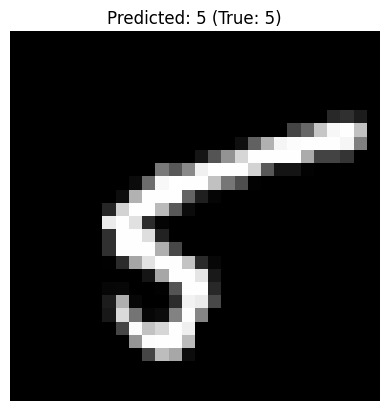

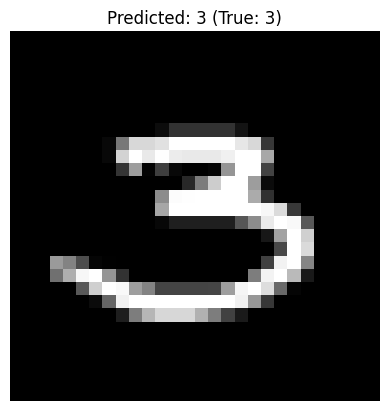

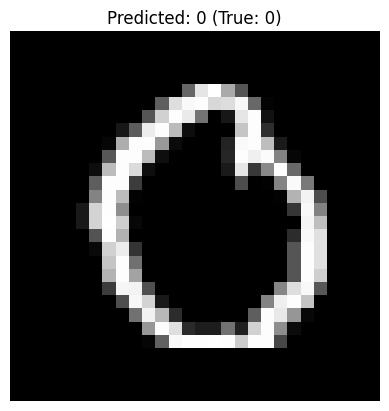

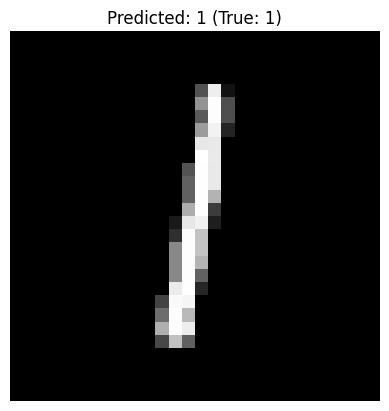

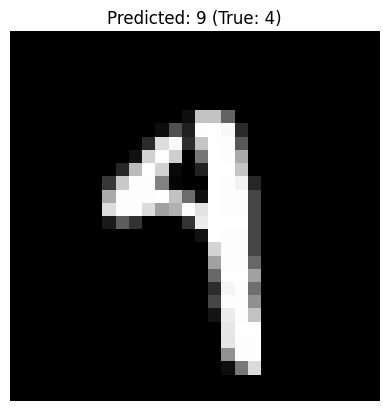

In [ ]:
import torch # import torch library
import torch.nn as nn # import nn module from torch library
import torch.optim as optim # import optim module from torch library to use optimizers
import torchvision # import torchvision library to use datasets and transforms (gets our mnist dataset)
import torchvision.transforms as transforms # import transforms module from torchvision library to use transforms (to transform the images to tensors and normalize them)

# 1. Load MNIST dataset
transform = transforms.Compose([
    # this next TOtesnor dose 2 things 
    # it gets that first dimention the grayscale value of the pixel, each original images pixel is between 0 and 255 (0 black and 255 white) .ToTensor divides every pixel by 255 to get the value between 0 and 1 
    # it then convert images 28x28 to tensor of shape (1, 28, 28) meaning a 1x28x28 tensor. 28x28 pixels = 784 pixels with 1 channel (grayscale i.e black/white 1 or 0 or in between) which is what we did in the last line
    transforms.ToTensor(),  
    # in the next step we normalize our image. from the prevois step our greyscale value is between 0-1 but it can be any value between 0 and 1 by normalizing we convert this range [-1, 1] to make it easier for the model to learn
    # we always want some common small scale for all images to be between, usally centered around 0. in our case here we normalize to -1 and 1 so all images intensity values are between -1 and 1
    # meaning we want, black images (0) == -1 and white images (255) == 1 and grayscale images (128) == 0. we do this by subtracting the mean from the original value and dividing by the standard deviation 
    # thats why we use 0.5 and 0.5 as the mean and std for the images (this is a common value used in deep learning) this is done to normalize the image to a common scale, if we use 0.5 and 0.5 as the mean and std, a value between 0 and 1 will be between -1 and 1
    # Normalized-Value=Original Value−Mean/Standard Deviation. EX: black image (0 value after .ToTensor) -> (0-0.5)/0.5 = -1, white image (255 value after .ToTensor) -> (1-0.5)/0.5 = 1, grayscale image (128 value after .ToTensor) -> (0.5-0.5)/0.5 = 0
    # if the values in between: lets say after .ToTensor our pixel (156) then it will first be between 0 and 1, 156/255 = 0.61, now we normalize -> (0.61-0.5)/0.5 = 0.22, so we get a value of 0.22 which is between -1 and 1 (normalized), so we can use this value to represent the pixel in the image
    # we do this so that we can train our model faster and more accurately because the model has to deal with a smaller range, it also helps gradient descent and prevents bias in the model towards larger values. it also helps the model update the weights and biases faster and more accurately
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1,1] and mean=0.5 and std=0.5
])

# 2. Load the dataset (one for training and one for testing)
# in the 2 ex's below we first load the data and then pass that training data into a data loader which is a way to iterate over the data in batches
# for ex the mnist Data set loads a lot of data so we want to load it in batches and feed our model in batches that way we don't have to load the whole dataset into memory
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) # download=True will download the dataset if not already present in the data folder
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # batch_size=64 means that we will train on 64 images at a time and shuffle=True means that we will shuffle the images every epoch

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) # we load into the data folder the mnist dataset (a dataset of handwritten digits 0-9)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)  # batch_size=1 for one image at a time and shuffle=True

# 3. Define a simple NN
class SimpleNN(nn.Module): # out NN inherits from nn.Module from torch
    def __init__(self): # this is the constructor of the class
        super(SimpleNN, self).__init__() # this calls the constructor of the parent class nn.Module to initialize the neural network (meaning the weights and biases in the model)
        # in the layers below we take the output of the previous layer and feed it into the next layer this is called a feedforward neural network (in tf we use dense layers which means each layer is fully connected to the next layer) here for ex each 128 neuron in the first layer output is connected to each 64 input neuron in the second layer and so on
        self.fc1 = nn.Linear(28*28, 128) # input layer (28*28=784 pixels) to hidden layer (128 neurons)
        self.fc2 = nn.Linear(128, 64) # we take the output of the first layer and feed it into the second layer ( so we had 128 from the hidden layer in last line) and we have 64 neurons as the output
        self.fc3 = nn.Linear(64, 10) # we take the 64 neurons from the second layer and feed it into the output layer with 10 outputs (10 neurons for 10 classes 0-9)

    def forward(self, x): # this is the forward pass of the neural network (the input x is passed through the layers of the network) in total we have 3 layers
        x = x.view(-1, 28*28)  # flatten the image to 784 pixels (28x28) the -1 means that we want to keep the batch size the same and flatten the image to 784 pixels
        x = torch.relu(self.fc1(x)) # apply ReLU activation function to the output of the first layer (this is a common activation function used in deep learning)
        x = torch.relu(self.fc2(x)) # apply ReLU activation function to the output of the second layer
        x = self.fc3(x)  # raw scores (logits), no activation function here (we will apply softmax in the loss function). the last layoer can no relu as its a output layer it simply outputs the logits (raw scores) the softmax is applied by the creiterion (loss function) in the next step. that converts the sroces to a probability distribution 0-1 where the highest score is the predicted class (0-9)
        return x # return the output of the last layer (the logits)

model = SimpleNN() # create an instance of the SimpleNN class (this is our model) and we can now use this model to train and test our data

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss() # this is the loss function we will use to train our model (this is a common loss function used in deep learning for multi-class classification problems) it applies softmax to the output of the model and then calculates the cross entropy loss between the predicted and true labels. we use this loss to then calculate the gradients in the backward pass and update the weights of the model
optimizer = optim.Adam(model.parameters(), lr=0.001) # this is the optimizer we will use to train our model (this is a common optimizer used in deep learning) it applies gradient descent to the weights of the model ( basically takes the gradients of the loss with respect to the weights and then updates the weights)

# 5. Training loop 
epochs = 3  # 3 epochs each epoch is a pass through the entire dataset in our case 60k images (the more epochs the more accurate the model will be but the more time it will take to train)
for epoch in range(epochs):
    running_loss = 0.0 # this is the loss for the current epoch (we will print this at the end of each epoch) just a vusualization of the loss for us
    for images, labels in trainloader: # this is the training loop we will iterate over the training data in batches of 64 images (the batch size we defined above) and labels are the true labels for the images (i.e if the image is a 0,1,2,3,4,5,6,7,8 or 9)
        optimizer.zero_grad() # this is the first step in the training loop we will set the gradients to zero (this is important because we don't want to accumulate the gradients from the previous batch) this is done to avoid the gradients from the previous batch to be added to the current batch
        outputs = model(images) # this is the forward pass we will pass the images through the model and get the output (the logits) this is done by calling the model (which is an instance of the SimpleNN class) and passing the images to it
        loss = criterion(outputs, labels) # this is the loss calculation we will calculate the loss between the output of the model (the logits) and the true labels (the labels) this is done by calling the criterion (which is an instance of the CrossEntropyLoss class) and passing the outputs and labels to it
        loss.backward() # after we calculate the loss in the previous step we will calculate the gradients of the loss with respect to the weights of the model (this is done by calling the backward method on the loss) this is called backpropagation (this is a common step in deep learning) after this we will have the gradients of the loss with respect to the weights of the model
        optimizer.step() # after we calculate the gradients in the previous step we will update the weights of the model (this is done by calling the step method on the optimizer) this is called gradient descent
        running_loss += loss.item() # this is just a visualization of the loss we will add the loss of the current batch to the running loss (this is done by calling the item method on the loss) this will give us the loss as a number (not a tensor) so we can print it
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader):.4f}") # this is just a visualization of the loss we will print the loss for the current epoch, each epoch our loss should decrease

print("Training complete ✅") # after this our training for the model class is done our model has now been updated with the weights and biases for the training data we passed to it

# 6. Inference: show image + prediction
model.eval()  # set model to evaluation mode (important!)

# Get a few test images to see the predictions
import matplotlib.pyplot as plt # to visualize the images we will use matplotlib

for i, (image, label) in enumerate(testloader): # from the testloader grab the images and labels (true values) and use a index i to keep track of the number of images we have seen
    with torch.no_grad(): # this is important because we don't want to calculate the gradients in the inference step (this is done by calling the no_grad method on torch) this will save memory and make the inference faster
        output = model(image) # pass the image in the NN and get the output, our constructor has no inputs but when we pass a vaiable in our model it will call the forward method in the SimpleNN class and pass the image to it and get the output as the raw scores (logits) from the last layer (no softmax applied her but still its a probability distribution)
        _, predicted = torch.max(output, 1)  # get the index of the highest logit, which is the predicted class (the max function returns the max value and its index we only need the index as we can get the image using the index ;ater and display the whole image insted of just the value, and use the label and index to get the value of the image)

    # Show the image
    plt.imshow(image.view(28,28), cmap='gray') # convert the image to 2D (28x28) and use the gray color map to display the image in black and white (when we loaded the msist data set you can see its a tensor of 1x28x28 so we need to convert it to 2D 28x28 to display it) the view method is used to reshape the tensor to 2D (28x28) and the cmap parameter is used to set the color map to gray (black and white) which we know it is as the first dimension is 1 meaning only 1 channel (grayscale) 
    plt.title(f"Predicted: {predicted.item()} (True: {label.item()})") # plot titel with the predicted class and the true class (since we have the index , predicted' we can use .item to get the value of the image and the label from the testloader)
    plt.axis('off') # turn off the axis (this is just for visualization purposes) we have a image so we don't need the axis
    plt.show() # show the image

    # Just show 5 examples
    if i == 4:
        break


# Bruh what kinda 4 is that 
⬜⬜⬜⬜⬜⬜⬜⬜🟧🟧🟧🟧🟧🟧🟧🟧⬜⬜⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜🟧🟧🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟧🟧⬜⬜⬜⬜⬜
⬜⬜⬜⬜🟧🟧🟧🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟧🟧🟧⬜⬜⬜⬜
⬜⬜⬜⬜🟧🟧🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟧🟧⬜⬜⬜⬜
⬜⬜⬜🟧🟧🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟧🟧⬜⬜⬜
⬜⬜🟧🟧🟨🟨🟨⬛⬛🟨🟨🟨🟨🟨🟨⬛⬛🟨🟨🟨🟧🟧⬜⬜
⬜⬜🟧🟨🟨⬛⬛🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨⬛⬛🟨🟨🟧⬜⬜
⬜🟧🟧🟨⬛🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨⬛🟨🟧🟧⬜
⬜🟧🟧🟨🟨🟨⬛⬛🟨🟨🟨🟨🟨🟨🟨🟨⬛⬛🟨🟨🟨🟧🟧⬜
⬜🟧🟧🟨🟨⬛⬛⬛⬛🟨🟨🟨🟨🟨🟨⬛⬛⬛⬛🟨🟨🟧🟧⬜
⬜🟧🟧🟨⬛⬛⬛⬛⬛⬛🟨🟨🟨🟨⬛⬛⬛⬛⬛⬛🟨🟧🟧⬜
⬜🟧🟧🟨⬛🟦🟦🟨🟨⬛🟨🟨🟨🟨⬛🟨🟨🟦🟦⬛🟨🟧🟧⬜
⬜🟧🟧🟦🟦🟦🟦🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟦🟦🟦🟦🟧🟧⬜
⬜🟧🟦🟦⬜🟦🟦🟨🟨🟨🟨🟨🟨🟨🟨🟨🟨🟦🟦⬜🟦🟦🟧⬜
⬜🟦🟦⬜⬜🟦🟦⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟦🟦⬜⬜🟦🟦⬜
🟦🟦⬜🟦🟦🟦⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜⬜🟦🟦🟦⬜🟦🟦
🟦🟦🟦🟦🟦🟦⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟦⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟦🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟦🟨⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛⬛🟨🟦🟦🟦🟦🟦
🟦🟦🟦🟦🟧🟧🟨⬛⬛⬛⬛⬛⬛⬛⬛⬛🟨🟨🟧🟧🟦🟦🟦🟦
⬜⬜⬜⬜🟧🟧🟧🟨🟨🟨⬛⬛⬛⬛🟨🟨🟨🟧🟧🟧⬜⬜⬜⬜
⬜⬜⬜⬜⬜🟧🟧🟧🟨🟨🟨🟨🟨🟨🟨🟨🟧🟧🟧⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧🟧⬜⬜⬜⬜⬜⬜
⬜⬜⬜⬜⬜⬜⬜⬜🟧🟧🟧🟧🟧🟧🟧🟧⬜⬜⬜⬜⬜⬜⬜⬜